In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time
import os
import copy
import csv
import pandas as pd
import albumentations as A

from PIL import Image

# 대화 모드
plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 데이터셋

In [2]:
# 이미지 리사이즈 및 정규화
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    #transforms.RandomAffine(20),
    #transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(10),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])

# albumentations 적용
#transform = A.Compose([
#    A.Resize(224,224),
#    A.HorizontalFlip(p=0.5),
#    A.RandomBrightness(limit=0.2, p=0.5),
#    A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
#    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
#    A.transforms.ToTensor()
#])

# dataset 및 dataloader
target_dir = "../input/hallym-2020-2-aicomp01/imgs/train"
dataset = torchvision.datasets.ImageFolder(root=target_dir,
                                           transform=transform)
class_names = dataset.classes

dataset_sizes = {}
dataset_sizes["train"] = int(0.8 * len(dataset))
dataset_sizes["val"] = len(dataset) - dataset_sizes["train"]

datasets = {}
datasets["train"], datasets["val"] = torch.utils.data.random_split(
    dataset, [dataset_sizes["train"], dataset_sizes["val"]])

dataloaders = {}
dataloaders["train"] = torch.utils.data.DataLoader(datasets["train"],
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=8)
dataloaders["val"] = torch.utils.data.DataLoader(datasets["val"],
                                                   batch_size=4,
                                                   shuffle=True,
                                                   num_workers=2)

for x in ["train", "val"]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
print(class_names)

Loaded 13969 images under train
Loaded 3493 images under val
Classes: 
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


## Utils

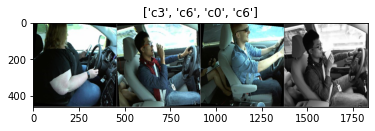

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.5, .5, .5])
    std = np.array([.5, .5, .5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# 학습 데이터의 배치
inputs, classes = next(iter(dataloaders['val']))

# 배치로부터 격자 형태의 이미지
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval() # 평가 모드; batch norm, dropout, ... X
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'ground truth:{class_names[labels[j]]}, predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    for i, data in enumerate(dataloaders["val"]):
        model.eval()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)
        
    avg_loss = loss_test / dataset_sizes["val"]
    avg_acc = acc_test.double() / dataset_sizes["val"]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))

## 모델생성

In [6]:
class VGG11(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
    ) -> None:
        super(VGG11, self).__init__()
        """
        특징 추출 레이어
        """
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        """
        Conv + Fully Conn 구성 대비,
        Conv + AdaptiveAvgPooling + Fully Connected 구성이 다음과 같은 장점을 가짐:
        1. 다양한 입력 이미지 사이즈
        2. 학습 파라미터 수 감소
        """
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        """
        앞선 conv layer에서 특징을 추출했다면,
        추출된 특징들(512개)을 이용해 분류
        """
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## EfficientNet Model

In [7]:
pip install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import geffnet
#ef_model = geffnet.efficientnet_b3(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2)
ef_model = geffnet.tf_efficientnet_b5_ns(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2)
#ef_model = geffnet.tf_efficientnet_b6_ns(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2)
ef_model.train()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


GenEfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
  

In [9]:
import geffnet
ef_model = geffnet.tf_efficientnet_b5_ns(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2)
ef_model.train()

# # # 이전 레이어 학습 정지
for param in ef_model.parameters():
    param.require_grad = True #원래 False

# # 새로운 레이어 추가
num_features = ef_model.classifier.in_features
features = list(ef_model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
ef_model.classifier = nn.Sequential(*features) # classifier 변경
print(ef_model)

GenEfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
  

In [10]:
# 모델 생성 및 사전훈련된 가중치 불러오기
model = VGG11()
WEIGHTS_URL = "https://download.pytorch.org/models/vgg11-bbd30ac9.pth"
model.load_state_dict(torch.hub.load_state_dict_from_url(WEIGHTS_URL, progress=True))
#model.load_state_dict(torch.load("../input/vgg11bbd30ac9pth/vgg11-bbd30ac9.pth"))
print(model.classifier[6].out_features) # 1000 


# 이전 레이어 학습 정지
for param in model.features.parameters():
    param.require_grad = False

# 새로운 레이어 추가
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model.classifier = nn.Sequential(*features) # classifier 변경
print(model)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth



1000
VGG11(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [11]:
ef_model.to(device)
    
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(ef_model.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(ef_model.parameters(),lr=0.0001, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 훈련전 모델 평가 및 시각화

Test before training

Evaluation completed in 1m 13s
Avg loss (test): 0.5764
Avg acc (test): 0.1148


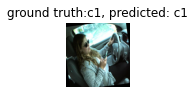

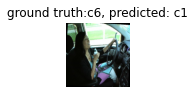

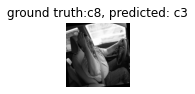

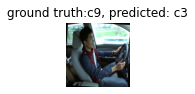

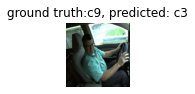

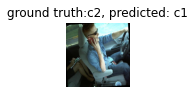

In [12]:
print("Test before training")
eval_model(ef_model, criterion)
visualize_model(ef_model)

In [13]:
from tqdm import tqdm

## 훈련

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        # training
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        # 데이터 반복
        for i, data in tqdm(enumerate(dataloaders["train"])):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 파라미터 경사도 초기화
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            # 역전파
            loss.backward()
            # 최적화
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
        
        avg_loss = loss_train / dataset_sizes["train"]
        avg_acc = acc_train.double() / dataset_sizes["train"]
        
        # validation
        model.train(False)
        model.eval()
            
        for i, data in tqdm(enumerate(dataloaders["val"])):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
        
        avg_loss_val = loss_val / dataset_sizes["val"]
        avg_acc_val = acc_val.double() / dataset_sizes["val"]
        
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [15]:
ef_model = train_model(ef_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
# 모델 저장
torch.save(ef_model.state_dict(), 'model.pt')

Epoch 0/10
----------


1747it [14:45,  1.97it/s]
874it [01:10, 12.44it/s]


Epoch 0 result: 
Avg loss (train): 0.0386
Avg acc (train): 0.9157
Avg loss (val): 0.0076
Avg acc (val): 0.9931
----------

Epoch 1/10
----------


1747it [14:49,  1.96it/s]
874it [01:10, 12.39it/s]


Epoch 1 result: 
Avg loss (train): 0.0071
Avg acc (train): 0.9861
Avg loss (val): 0.0051
Avg acc (val): 0.9946
----------

Epoch 2/10
----------


1747it [14:47,  1.97it/s]
874it [01:10, 12.36it/s]

Epoch 2 result: 
Avg loss (train): 0.0044
Avg acc (train): 0.9909
Avg loss (val): 0.0045
Avg acc (val): 0.9963
----------

Epoch 3/10
----------



1747it [14:46,  1.97it/s]
874it [01:09, 12.58it/s]

Epoch 3 result: 
Avg loss (train): 0.0040
Avg acc (train): 0.9911
Avg loss (val): 0.0066
Avg acc (val): 0.9934
----------

Epoch 4/10
----------



1747it [14:45,  1.97it/s]
874it [01:10, 12.44it/s]

Epoch 4 result: 
Avg loss (train): 0.0021
Avg acc (train): 0.9951
Avg loss (val): 0.0053
Avg acc (val): 0.9954
----------

Epoch 5/10
----------



1747it [14:45,  1.97it/s]
874it [01:09, 12.53it/s]

Epoch 5 result: 
Avg loss (train): 0.0024
Avg acc (train): 0.9958
Avg loss (val): 0.0053
Avg acc (val): 0.9960
----------

Epoch 6/10
----------



1747it [14:48,  1.97it/s]
874it [01:10, 12.44it/s]


Epoch 6 result: 
Avg loss (train): 0.0018
Avg acc (train): 0.9963
Avg loss (val): 0.0047
Avg acc (val): 0.9966
----------

Epoch 7/10
----------


1747it [14:47,  1.97it/s]
874it [01:09, 12.53it/s]

Epoch 7 result: 
Avg loss (train): 0.0018
Avg acc (train): 0.9959
Avg loss (val): 0.0037
Avg acc (val): 0.9966
----------

Epoch 8/10
----------



1747it [14:45,  1.97it/s]
874it [01:10, 12.46it/s]


Epoch 8 result: 
Avg loss (train): 0.0014
Avg acc (train): 0.9974
Avg loss (val): 0.0024
Avg acc (val): 0.9983
----------

Epoch 9/10
----------


1747it [14:43,  1.98it/s]
874it [01:10, 12.46it/s]


Epoch 9 result: 
Avg loss (train): 0.0017
Avg acc (train): 0.9967
Avg loss (val): 0.0048
Avg acc (val): 0.9960
----------


Training completed in 159m 32s
Best acc: 0.9983


## 모델 평가

In [16]:
eval_model(ef_model, criterion)


Evaluation completed in 1m 11s
Avg loss (test): 0.0027
Avg acc (test): 0.9980


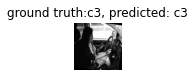

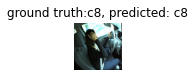

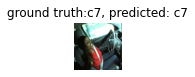

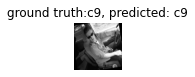

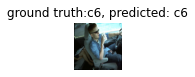

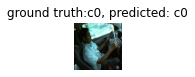

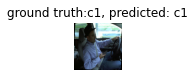

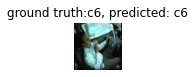

In [17]:
visualize_model(ef_model, num_images=8)

## 제출

In [18]:
# 모델 준비
#model = VGG11(10)
#model = geffnet.create_model('efficientnet_b3', pretrained=True)

# # # 이전 레이어 학습 정지
#for param in ef_model.parameters():
#    param.require_grad = False

# # 새로운 레이어 추가
#num_features = ef_model.classifier.in_features
#features = list(ef_model.classifier.children())[:-1]
#features.extend([nn.Linear(num_features, len(class_names))])
#ef_model.classifier = nn.Sequential(*features) # classifier 변경


#model.load_state_dict(torch.load("model.pt"),strict=False)

ef_model.to(device)
ef_model.eval()

GenEfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
  

In [19]:
# test 이미지 경로
paths = []
target_dir = "../input/hallym-2020-2-aicomp01/imgs/test"
for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
    for fname in sorted(fnames):
        path = os.path.join(target_dir, fname)
        paths += [path]

In [20]:
predictions = []

batch_size = 4
for i in tqdm(range(round((len(paths) / batch_size) + 0.5))):
    # 이미지 batch 처리
    batch = paths[i*batch_size:(i+1)*batch_size]
    inputs = []
    for j, path in enumerate(batch):
        img = Image.open(path).convert('RGB')
        img = transform(img)
        inputs.append(img)

    inputs = torch.stack(inputs).to(device)

    # prediction
    preds = ef_model(inputs)
    predictions += [preds.detach().cpu().numpy()]
    del preds
    torch.cuda.empty_cache()

100%|██████████| 1241/1241 [06:09<00:00,  3.36it/s]


In [21]:
# write csv
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["img","category"])
    for i, batch in enumerate(predictions):
        for j, pred in enumerate(batch):
            row = [os.path.basename(paths[i * batch_size + j]), f"c{pred.argmax()}"]
            writer.writerow(row)